In [1]:
import os
import sys
import argparse
import joblib

PYMO_DIR = os.path.join('/home/serverai/ltdoanh/Motion_Diffusion', 'datasets', 'pymo')
if PYMO_DIR not in sys.path:
    sys.path.insert(0, PYMO_DIR)

import torch
import numpy as np

fig = 5

In [2]:
scale_factor_path = "./checkpoints/beat/VQKL_Sobolev/scale_factor.txt" 
scale_val = None

print(f"Đang đọc giá trị từ {scale_factor_path}...")

if os.path.exists(scale_factor_path):
    with open(scale_factor_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.strip().startswith("scale_factor"):
                parts = line.split('=')
                if len(parts) > 1:
                    val_str = parts[1].strip()
                    try:
                        scale_val = float(val_str)
                        print(f"--> Tìm thấy scale_factor: {scale_val}")
                    except ValueError:
                        print(f"--> LỖI: Không thể chuyển '{val_str}' sang float.")
                        scale_val = None
                break
else:
    print(f"LỖI: Không tìm thấy file {scale_factor_path}. Vui lòng kiểm tra lại đường dẫn.")
    exit(1) 

if scale_val is None:
    print("LỖI: Không đọc được giá trị scale_factor trong file.")
    exit(1)

Đang đọc giá trị từ ./checkpoints/beat/VQKL_Sobolev/scale_factor.txt...
--> Tìm thấy scale_factor: 0.4369379


In [3]:
class Config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    checkpoints_dir = "./checkpoints"
    dataset_name = 'beat'
    
    vqkl_name = 'VQKL_Sobolev'  
    
    diffusion_name = 'vqkl_diff' 
    
    checkpoint_name = 'best_model.pt' 
    result_dir = "./results"

    scale_factor = scale_val

    latent_dim = 512
    num_layers = 8
    num_heads = 8
    ff_size = 1024
    dropout = 0.2    
    no_eff = False  
    freeze_vqkl = True

    use_kl_posterior = True 

    diffusion_steps = 1000
    noise_schedule = 'linear' 
    
    sampler = 'ddim'
    ddim_eta = 0.0 
    
    guidance_scale = 0

class ClassifierFreeGuidanceModel(torch.nn.Module):
    def __init__(self, model, guidance_scale):
        super().__init__()
        self.model = model
        self.guidance_scale = guidance_scale

    def forward(self, x, t, y=None):
        if self.guidance_scale == 1.0:
            return self.model(x, t, y)

        texts = y['text']
        lengths = y['length']
        batch_size = len(texts)

        uncond_texts = [""] * batch_size

        x_in = torch.cat([x, x], dim=0)

        t_in = torch.cat([t, t], dim=0)

        y_in = {
            'text': texts + uncond_texts,  
            'length': lengths + lengths   
        }

        model_output = self.model(x_in, t_in, y=y_in)

        eps_cond, eps_uncond = model_output.chunk(2, dim=0)

        eps = eps_uncond + self.guidance_scale * (eps_cond - eps_uncond)

        return eps

from models.vq_diffusion import create_vqkl_latent_diffusion, VQKLLatentDiffusionWrapper
from models.gaussian_diffusion import (
    GaussianDiffusion, get_named_beta_schedule,
    ModelMeanType, ModelVarType, LossType
)

def load_models(args):
    print("\nLoading model...")

    model = create_vqkl_latent_diffusion(
        dataset_name=args.dataset_name,
        vqkl_name=args.vqkl_name,
        checkpoints_dir=args.checkpoints_dir,
        device=args.device,
        freeze_vqkl=args.freeze_vqkl,
        scale_factor=args.scale_factor,

        use_kl_posterior=args.use_kl_posterior, 
        
        latent_dim=args.latent_dim,
        num_layers=args.num_layers,
        num_heads=args.num_heads,
        ff_size=args.ff_size,
        dropout=args.dropout,
        no_eff=args.no_eff
    )

    checkpoint_path = os.path.join(
        args.checkpoints_dir,
        args.dataset_name,
        args.diffusion_name, 
        'model',
        args.checkpoint_name
    )

    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

    print(f"Loading checkpoint: {checkpoint_path}")
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
    except Exception:
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    try:
        model.load_state_dict(checkpoint['model_state_dict'], strict=True)
        print("Checkpoint loaded (strict)")
    except Exception as e:
        print(f"Strict loading failed: {e}")
        print("Retrying with strict=False (Missing keys might be acceptable usually VQ parts)...")
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print("Checkpoint loaded (loose)")

    model.eval()

    betas = get_named_beta_schedule(args.noise_schedule, args.diffusion_steps)
    diffusion = GaussianDiffusion(
        betas=betas,
        model_mean_type=ModelMeanType.EPSILON, 
        model_var_type=ModelVarType.FIXED_SMALL,
        loss_type=LossType.RESCALED_L1, 
        rescale_timesteps=False
    )

    print("Model and diffusion ready")
    return model, diffusion

@torch.no_grad()
def generate_motion(model, diffusion, text_prompts, lengths, args, mean, std):
    """Generate motion from text with CFG"""
    
    print(f"\n Generating motion for {len(text_prompts)} prompts...")
    print(f"   Guidance Scale: {args.guidance_scale}")

    raw_wrapped_model = VQKLLatentDiffusionWrapper(model)
    cfg_model = ClassifierFreeGuidanceModel(raw_wrapped_model, args.guidance_scale)
    
    B = len(text_prompts)
    T_latent = model.num_frames
    latent_dim = getattr(model.vqkl, 'embed_dim', model.vqkl.code_dim)
    
    shape = (B, T_latent, latent_dim)
    
    model_kwargs = {
        'y': {
            'text': text_prompts,
            'length': lengths,
        }
    }
    
    if args.sampler == 'ddim':
        print(f"Sampling with DDIM (eta={args.ddim_eta})...")
        latent_samples = diffusion.ddim_sample_loop(
            cfg_model,
            shape,
            clip_denoised=False,
            model_kwargs=model_kwargs,
            device=args.device,
            progress=True,
            eta=args.ddim_eta
        )
    else:
        print("Sampling with DDPM...")
        latent_samples = diffusion.p_sample_loop(
            cfg_model, 
            shape,
            clip_denoised=False,
            model_kwargs=model_kwargs,
            device=args.device,
            progress=True
        )
    
    print(f"Latent shape: {latent_samples.shape}")
    
    print("Decoding to motion...")
    motion = model.decode_from_latent(latent=latent_samples)
    
    print(f"Motion shape: {motion.shape}")
    
    motion_np = motion.cpu().numpy()
    if motion_np.shape[1] == 264:
        motion_np = motion_np.transpose(0, 2, 1)
    
    motion_denorm = motion_np * std + mean
    
    print(f" Generation complete: {motion_denorm.shape}")
    
    return motion_denorm

def main():
    args = Config()
    stats_path = os.path.join('/home/serverai/ltdoanh/Motion_Diffusion', 'global_pipeline.pkl')
    
    print(f"Loading stats from: {stats_path}")
    pipeline = joblib.load(stats_path)
    scaler = pipeline.named_steps['stdscale']
    mean = scaler.data_mean_
    std = scaler.data_std_
    print(f" Stats loaded (dim={len(mean)})")

    model, diffusion = load_models(args)
    
    text_prompts = [
        "the first thing i like to do on weekends is relaxing and i'll go shopping if i'm not that tired",
    ]
    
    lengths = [45] * len(text_prompts)
    
    motion = generate_motion(model, diffusion, text_prompts, lengths, args, mean, std)
    
    os.makedirs(args.result_dir, exist_ok=True)
    save_path = os.path.join(args.result_dir, f'vqkl_diffusion_hierarchical_v{fig}.npy')
    np.save(save_path, motion)
    
    print(f" Saved to: {save_path}")
    print("\n" + "="*60)
    print("INFERENCE COMPLETED!")
    print("="*60)

if __name__ == "__main__":
    main()

Loading stats from: /home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl
 Stats loaded (dim=264)

Loading model...
Using fallback checkpoint: ./checkpoints/beat/VQKL_Sobolev/model/latest.tar
[INFO] Using scale_factor=0.436938 for latent normalization
[INFO] KL posterior mode: True
Loading VQ-KL from ./checkpoints/beat/VQKL_Sobolev/model/latest.tar
VQ-KL loaded successfully
VQ-KL frozen


/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


VQKLLatentDiffusion initialized:
  - Input features: 512
  - Latent seq length: 45
  - Transformer latent dim: 512
  - Scale factor: 0.436938
Loading checkpoint: ./checkpoints/beat/vqkl_diff/model/best_model.pt
Checkpoint loaded (strict)
Model and diffusion ready


/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 Generating motion for 1 prompts...
   Guidance Scale: 0
Sampling with DDIM (eta=0.0)...


100%|██████████| 1000/1000 [01:54<00:00,  8.70it/s]


Latent shape: torch.Size([1, 45, 512])
Decoding to motion...
Motion shape: torch.Size([1, 360, 264])
 Generation complete: (1, 360, 264)
 Saved to: ./results/vqkl_diffusion_hierarchical_v5.npy

INFERENCE COMPLETED!


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import pandas as pd

# Setup path
PYOM_DIR = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d


from sklearn.pipeline import Pipeline

pipeline_path = "/home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl"
print(f"📦 Loading pipeline from: {pipeline_path}")
pipeline = joblib.load(pipeline_path)

ref_bvh_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/2_scott_0_55_55.bvh"

if os.path.exists(ref_bvh_path):
    print(f"🔧 Processing reference BVH: {os.path.basename(ref_bvh_path)}")
    parser = BVHParser()
    ref_data = parser.parse(ref_bvh_path)
    
    steps_before_np = []
    np_found = False
    
    for name, step in pipeline.steps:
        if name == 'np': 
            np_found = True
            break
        steps_before_np.append((name, step))
    
    if np_found and steps_before_np:
        print(f"   Running reference data through pre-processing steps: {[n for n, _ in steps_before_np]}...")
        
        pre_pipeline = Pipeline(steps_before_np)
        
        processed_ref = pre_pipeline.fit_transform([ref_data])
        
        template_data = processed_ref[0]
        
        print(f"   Template shape after preprocessing: {template_data.values.shape}") 
        
        if template_data.values.shape[1] == 264:
            # Gán template đúng shape vào Numpyfier
            pipeline.named_steps['np'].org_mocap_ = template_data
            print("  Skeleton structure injected with CORRECT dimensions (264)!")
        else:
            print(f" Warning: Processed shape is {template_data.values.shape[1]}, but model output is 264.")
            print("   Visualization might still fail.")
            
    else:
        print(" Could not isolate steps before Numpyfier.")
        pipeline.named_steps['np'].org_mocap_ = ref_data

else:
    print(f" Reference BVH not found at {ref_bvh_path}")
    sys.exit(1)

📦 Loading pipeline from: /home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl
🔧 Processing reference BVH: 2_scott_0_55_55.bvh
   Running reference data through pre-processing steps: ['param', 'rcpn', 'delta', 'const']...
   Template shape after preprocessing: (3720, 264)
  Skeleton structure injected with CORRECT dimensions (264)!



 Loading motion: /home/serverai/ltdoanh/Motion_Diffusion/results/vqkl_diffusion_hierarchical_v5.npy
   Raw Input Shape: (360, 264)
   Raw Input Range: -447.22 to 475.65
 Detected large values (Real-scale data). Re-normalizing for pipeline compatibility...
   Normalized Range: -115.73 to 90.08

 Performing inverse transform...
positions 2 eulers is not supported
    Inverse transform successful!
   Final Motion Range (cm): -2380.61 to 475.65

 Visualizing Frame 179...


<Figure size 1000x800 with 0 Axes>

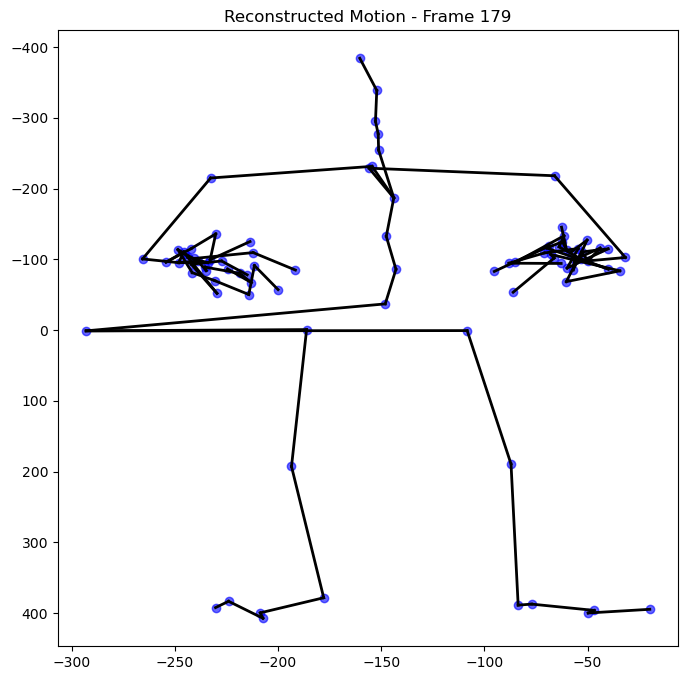

<Figure size 1000x800 with 0 Axes>

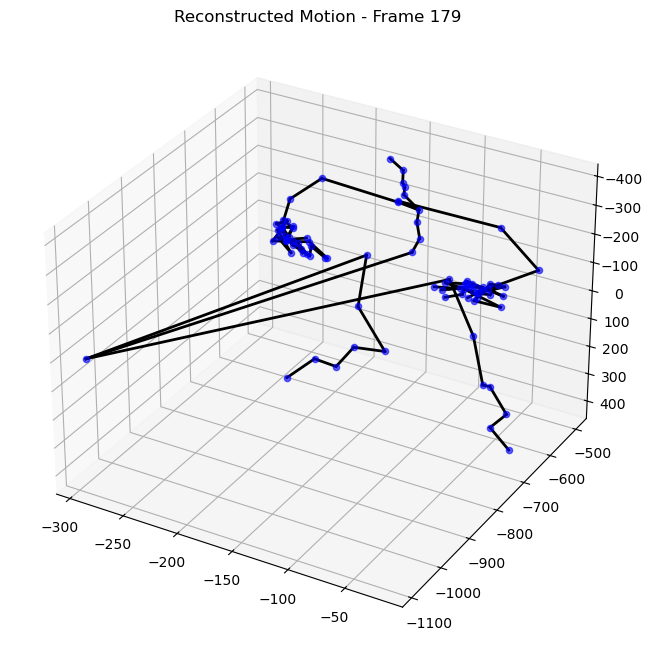

In [5]:
npy_path = f"/home/serverai/ltdoanh/Motion_Diffusion/results/vqkl_diffusion_hierarchical_v{fig}.npy"
print(f"\n Loading motion: {npy_path}")
motion_data = np.load(npy_path)

if motion_data.ndim == 3:
    motion_data = motion_data[0]

print(f"   Raw Input Shape: {motion_data.shape}")
print(f"   Raw Input Range: {motion_data.min():.2f} to {motion_data.max():.2f}")

scaler = pipeline.named_steps['stdscale']
mean = scaler.data_mean_
std = scaler.data_std_

if np.abs(motion_data).max() > 100:
    print(" Detected large values (Real-scale data). Re-normalizing for pipeline compatibility...")
    motion_data = (motion_data - mean) / std
    print(f"   Normalized Range: {motion_data.min():.2f} to {motion_data.max():.2f}")
else:
    print(" Data seems to be already normalized.")

print("\n Performing inverse transform...")
try:
    reconstructed = pipeline.inverse_transform([motion_data])
    mocap_data = reconstructed[0]
    
    print("    Inverse transform successful!")
    
    df = mocap_data.values
    print(f"   Final Motion Range (cm): {df.min().min():.2f} to {df.max().max():.2f}")
    
    frame = 179
    print(f"\n Visualizing Frame {frame}...")
    
    plt.figure(figsize=(10, 8)) 
    draw_stickfigure(mocap_data, frame=frame)
    plt.gca().invert_yaxis()
    plt.title(f"Reconstructed Motion - Frame {frame}")
    plt.show()

    plt.figure(figsize=(10, 8)) 
    draw_stickfigure3d(mocap_data, frame=frame)
    plt.gca().invert_zaxis()
    plt.title(f"Reconstructed Motion - Frame {frame}")
    plt.show()
    
except Exception as e:
    print(f"\n ERROR during visualization: {e}")
    import traceback
    traceback.print_exc()

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import gudhi as gd
import requests
from PIL import Image
from io import BytesIO

# --- 1. HÀM TRÍCH XUẤT 13 ĐẶC TRƯNG TOPO (THEO YÊU CẦU TRƯỚC) ---

def extract_molecular_topo_features(h0_diag, h1_diag, max_filt=1.0, num_units=1.0):
    """Trích xuất 13 đặc trưng từ sơ đồ persistence của Feature Map"""
    features = []
    
    # H0 Stats
    p0 = h0_diag[:, 1] - h0_diag[:, 0]
    p0_sorted = np.sort(p0[np.isfinite(h0_diag[:, 1])])[::-1]
    features.append(p0_sorted[1] if len(p0_sorted) > 1 else 0.0) # 1. 2nd longest
    features.append(p0_sorted[2] if len(p0_sorted) > 2 else 0.0) # 2. 3rd longest
    p0_filt = p0[h0_diag[:, 1] <= max_filt]
    features.append(np.sum(p0_filt)) # 3. Sum H0
    features.append(np.mean(p0_filt) if len(p0_filt) > 0 else 0.0) # 4. Mean H0

    # H1 Stats
    p1 = h1_diag[:, 1] - h1_diag[:, 0]
    if len(p1) > 0:
        idx_max = np.argmax(p1)
        features.append(h1_diag[idx_max, 0]) # 5. Onset longest H1
        features.append(p1[idx_max])          # 6. Length longest H1
        
        long_h1 = h1_diag[p1 > 0.1] # Ngưỡng 0.1 thay cho 1.5A vì giá trị feature map thường nhỏ
        features.append(np.min(long_h1[:, 0]) if len(long_h1) > 0 else 0.0) # 7. Smallest onset
        features.append(np.mean((long_h1[:, 0] + long_h1[:, 1])/2) if len(long_h1) > 0 else 0.0) # 8. Mean midpoint
        
        # Các đặc trưng mật độ (9, 10)
        features.append(np.sum((h1_diag[:, 0] <= 0.6) & (h1_diag[:, 1] >= 0.4)) / num_units)
        features.append(np.sum(((h1_diag[:, 0] < 0.4)) | (h1_diag[:, 1] > 0.6)) / num_units)
        
        p1_filt = p1[h1_diag[:, 1] <= max_filt]
        features.append(np.sum(p1_filt)) # 11. Sum H1
        features.append(np.mean(p1_filt) if len(p1_filt) > 0 else 0.0) # 12. Mean H1
    else:
        features.extend([0.0] * 8)
    
    features.append(0.0) # 13. H2 (thường bằng 0 trên feature map 2D)
    return np.array(features)

# --- 2. PIPELINE: CNN FEATURE EXTRACTION -> TDA ON FEATURE MAP ---

def run_feature_map_tda_pipeline(urls):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Sử dụng ResNet18
    resnet = models.resnet18(pretrained=True).to(device)
    # Lấy backbone đến lớp layer3 để có feature map 28x28
    modules = list(resnet.children())
    backbone_to_layer3 = nn.Sequential(*modules[:7]).to(device)
    # Lớp Pooling cuối để lấy visual embedding (512 chiều)
    full_backbone = nn.Sequential(*modules[:-1]).to(device)
    
    backbone_to_layer3.eval()
    full_backbone.eval()

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    embeddings = []

    for url in urls:
        resp = requests.get(url)
        img_pil = Image.open(BytesIO(resp.content)).convert('RGB')
        img_t = preprocess(img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            # Bước 1: Lấy Visual Embedding chuẩn (512-d)
            visual_feat = full_backbone(img_t).view(1, -1)
            visual_feat = F.normalize(visual_feat, p=2, dim=1)

            # Bước 2: Lấy Feature Map từ Layer 3 (Shape: 1, 256, 28, 28)
            f_map = backbone_to_layer3(img_t) 
            # Trung bình cộng các channels để tạo "Activation Map" duy nhất (28x28)
            activation_map = torch.mean(f_map, dim=1).squeeze().cpu().numpy()
            
            # Chuẩn hóa map về [0, 1] để làm Filtration
            map_min, map_max = activation_map.min(), activation_map.max()
            norm_map = (activation_map - map_min) / (map_max - map_min + 1e-8)

        # Bước 3: TDA trên Activation Map
        cc = gd.CubicalComplex(dimensions=norm_map.shape, top_dimensional_cells=norm_map.flatten())
        persistence = cc.persistence()
        
        h0_diag = np.array([p[1] for p in persistence if p[0] == 0])
        h1_diag = np.array([p[1] for p in persistence if p[0] == 1])
        
        # Trích xuất 13 đặc trưng topo từ "địa hình" của các neuron
        topo_stats = extract_molecular_topo_features(h0_diag, h1_diag, max_filt=1.0, num_units=norm_map.size)
        topo_tensor = torch.tensor(topo_stats).unsqueeze(0).to(device).float()
        topo_feat = F.normalize(topo_tensor, p=2, dim=1)

        # Bước 4: Kết hợp
        embeddings.append(F.normalize(topo_feat, p=2, dim=1))

    similarity = torch.mm(embeddings[0], embeddings[1].t()).item()
    print(f"\n>>> ĐỘ TƯƠNG ĐỒNG (Topology of Layer3 Maps): {similarity:.4f}")

# URLs test
u5 = "https://sieupet.com/sites/default/files/pictures/images/maxresdefault-4.jpg"
u6 = "https://cf.shopee.ph/file/ae5c6f681f504a5e82077338db6f65e7"
run_feature_map_tda_pipeline([u5, u6])

/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



>>> ĐỘ TƯƠNG ĐỒNG (Topology of Layer3 Maps): 0.9373


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import gudhi as gd
import requests
from PIL import Image
from io import BytesIO

def run_bottleneck_pipeline(urls):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Khởi tạo mô hình ResNet18 và trích xuất đến Layer 3
    weights = models.ResNet18_Weights.IMAGENET1K_V1 
    resnet = models.resnet18(weights=weights).to(device)
    modules = list(resnet.children())
    # Layer 3 (index 7) cho Feature Map kích thước 28x28
    backbone_to_layer3 = nn.Sequential(*modules[:7]).to(device)
    backbone_to_layer3.eval()

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    all_h0_diagrams = []
    all_h1_diagrams = []

    for url in urls:
        print(f"Đang xử lý cấu trúc ảnh: {url[:50]}...")
        resp = requests.get(url)
        img_pil = Image.open(BytesIO(resp.content)).convert('RGB')
        img_t = preprocess(img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            # Bước 2: Lấy Feature Map (1, 256, 28, 28)
            f_map = backbone_to_layer3(img_t) 
            # Tạo bản đồ kích hoạt trung bình (Activation Map)
            activation_map = torch.mean(f_map, dim=1).squeeze().cpu().numpy()
            
            # Chuẩn hóa về [0, 1] để đảm bảo tính ổn định khi tính khoảng cách
            map_min, map_max = activation_map.min(), activation_map.max()
            norm_map = (activation_map - map_min) / (map_max - map_min + 1e-8)

        # Bước 3: Tính toán Cubical Complex để lấy PD
        cc = gd.CubicalComplex(dimensions=norm_map.shape, top_dimensional_cells=norm_map.flatten())
        persistence = cc.persistence()
        
        # Lưu trữ các sơ đồ PD cho H0 và H1 (loại bỏ các điểm vô hạn để tính Bottleneck)
        h0_diag = np.array([p[1] for p in persistence if p[0] == 0 and np.isfinite(p[1][1])])
        h1_diag = np.array([p[1] for p in persistence if p[0] == 1 and np.isfinite(p[1][1])])
        
        all_h0_diagrams.append(h0_diag)
        all_h1_diagrams.append(h1_diag)

    # Bước 4: Tính Bottleneck Distance giữa 2 ảnh
    # Lưu ý: Bottleneck là khoảng cách (càng nhỏ càng giống nhau)
    dist_h0 = gd.bottleneck_distance(all_h0_diagrams[0], all_h0_diagrams[1])
    dist_h1 = gd.bottleneck_distance(all_h1_diagrams[0], all_h1_diagrams[1])

    print("\n" + "="*30)
    print(f">>> KHOẢNG CÁCH BOTTLENECK H0: {dist_h0:.4f}")
    print(f">>> KHOẢNG CÁCH BOTTLENECK H1: {dist_h1:.4f}")
    
    # Tính độ tương đồng xấp xỉ (Similarity) từ khoảng cách
    # Công thức: 1 / (1 + distance)
    sim_h0 = 1 / (1 + dist_h0)
    sim_h1 = 1 / (1 + dist_h1)
    print(f"\n>>> ĐỘ TƯƠNG ĐỒNG CẤU TRÚC H0: {sim_h0:.4f}")
    print(f">>> ĐỘ TƯƠNG ĐỒNG CẤU TRÚC H1: {sim_h1:.4f}")
    print("="*30)

# URLs test (Chai đỏ vs Chai vàng)
u5 = "https://sieupet.com/sites/default/files/pictures/images/maxresdefault-4.jpg"
u6 = "https://cf.shopee.ph/file/ae5c6f681f504a5e82077338db6f65e7"
run_bottleneck_pipeline([u5, u6])

Đang xử lý cấu trúc ảnh: https://sieupet.com/sites/default/files/pictures/i...
Đang xử lý cấu trúc ảnh: https://cf.shopee.ph/file/ae5c6f681f504a5e82077338...

>>> KHOẢNG CÁCH BOTTLENECK H0: 0.0331
>>> KHOẢNG CÁCH BOTTLENECK H1: 0.3879

>>> ĐỘ TƯƠNG ĐỒNG CẤU TRÚC H0: 0.9679
>>> ĐỘ TƯƠNG ĐỒNG CẤU TRÚC H1: 0.7205


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import gudhi as gd
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# --- 1. HÀM TẠO PERSISTENCE IMAGE (VECTORIZED CHO TỐC ĐỘ) ---

def make_pi_vectorized(diagram, res=50, sigma=0.02):
    """Biến đổi PD thành PI (50x50) dựa trên Feature Map [0,1]"""
    if len(diagram) == 0:
        return np.zeros((res, res))
    
    # 1. Chuyển sang tọa độ (Birth, Persistence)
    # Vì Activation Map đã chuẩn hóa [0,1], max birth/persistence là 1.0
    birth = diagram[:, 0]
    persistence = diagram[:, 1] - diagram[:, 0]
    persistence = np.clip(persistence, 0, 1.0) # Xử lý các điểm inf nếu có

    # Tạo lưới pixel
    grid = np.linspace(0, 1, res)
    b_grid, p_grid = np.meshgrid(grid, grid)
    
    pi = np.zeros((res, res))
    
    # Duyệt qua từng điểm trong PD (vectorized qua lưới)
    for b_u, p_u in zip(birth, persistence):
        # Hàm trọng số: f(p) = p (tỉ lệ thuận với độ bền)
        weight = p_u 
        # Gaussian kernel trên toàn lưới
        gaussian = np.exp(-((b_grid - b_u)**2 + (p_grid - p_u)**2) / (2 * sigma**2))
        pi += weight * gaussian

    # Đảo trục Y để khớp định dạng (Persistence tăng từ dưới lên)
    return np.flipud(pi)

# --- 2. PIPELINE: CNN -> TDA -> PERSISTENCE IMAGES ---

def run_feature_map_pi_pipeline(urls):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Khởi tạo ResNet18 và lấy đến Layer 3
    resnet = models.resnet18(pretrained=True).to(device)
    modules = list(resnet.children())
    backbone_to_layer3 = nn.Sequential(*modules[:7]).to(device)
    backbone_to_layer3.eval()

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    pi_embeddings = []

    for url in urls:
        print(f"Đang xử lý Feature Map: {url[:40]}...")
        resp = requests.get(url)
        img_pil = Image.open(BytesIO(resp.content)).convert('RGB')
        img_t = preprocess(img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            # Bước 1: Trích xuất Feature Map (256 channels, 28x28)
            f_map = backbone_to_layer3(img_t) 
            activation_map = torch.mean(f_map, dim=1).squeeze().cpu().numpy()
            
            # Chuẩn hóa map về [0, 1]
            map_min, map_max = activation_map.min(), activation_map.max()
            norm_map = (activation_map - map_min) / (map_max - map_min + 1e-8)

        # Bước 2: Cubical Complex lấy PD
        cc = gd.CubicalComplex(dimensions=norm_map.shape, top_dimensional_cells=norm_map.flatten())
        persistence = cc.persistence()
        
        h0_diag = np.array([p[1] for p in persistence if p[0] == 0 and np.isfinite(p[1][1])])
        h1_diag = np.array([p[1] for p in persistence if p[0] == 1 and np.isfinite(p[1][1])])
        
        # Bước 3: Tạo Persistence Images (PI) cho H0 và H1
        pi_h0 = make_pi_vectorized(h0_diag, res=24, sigma=0.03)
        pi_h1 = make_pi_vectorized(h1_diag, res=24, sigma=0.03)
        
        # Bước 4: Chuyển PI thành Vector đặc trưng (50x50x2 = 5000 chiều)
        combined_pi = np.concatenate([pi_h0.flatten(), pi_h1.flatten()])
        pi_tensor = torch.tensor(combined_pi).unsqueeze(0).to(device).float()
        
        # Chuẩn hóa L2 để so khớp
        pi_embeddings.append(F.normalize(pi_tensor, p=2, dim=1))

    # Bước 5: Tính Cosine Similarity giữa 2 vector PI
    similarity = torch.mm(pi_embeddings[0], pi_embeddings[1].t()).item()
    print("\n" + "="*40)
    print(f">>> ĐỘ TƯƠNG ĐỒNG PI (Dựa trên Layer3 Feature Map): {similarity:.4f}")
    print("="*40)

# Chạy thử nghiệm
u5 = "https://i.pinimg.com/originals/8b/5d/97/8b5d978b8f44e581f9658d85d6ef129e.jpg"
u6 = "https://cf.shopee.ph/file/ae5c6f681f504a5e82077338db6f65e7"
run_feature_map_pi_pipeline([u5, u6])

/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Đang xử lý Feature Map: https://i.pinimg.com/originals/8b/5d/97/...
Đang xử lý Feature Map: https://cf.shopee.ph/file/ae5c6f681f504a...

>>> ĐỘ TƯƠNG ĐỒNG PI (Dựa trên Layer3 Feature Map): 0.5173


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import gudhi as gd
import requests
from PIL import Image
from io import BytesIO

# --- 1. HÀM TẠO PERSISTENCE IMAGE (GIỮ NGUYÊN TỪ BẢN TRƯỚC) ---
def make_pi_vectorized(diagram, res=24, sigma=0.03):
    if len(diagram) == 0:
        return np.zeros((res, res))
    
    birth = diagram[:, 0]
    persistence = diagram[:, 1] - diagram[:, 0]
    persistence = np.clip(persistence, 0, 1.0)

    grid = np.linspace(0, 1, res)
    b_grid, p_grid = np.meshgrid(grid, grid)
    
    pi = np.zeros((res, res))
    for b_u, p_u in zip(birth, persistence):
        weight = p_u 
        gaussian = np.exp(-((b_grid - b_u)**2 + (p_grid - p_u)**2) / (2 * sigma**2))
        pi += weight * gaussian
    return np.flipud(pi)

# --- 2. PIPELINE: ViT -> TOKEN RESHAPE -> TDA -> PI ---
def run_vit_tda_pipeline(urls):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Sử dụng ViT-B/16 Pre-trained
    # vit_b_16 chia ảnh 224x224 thành 14x14 patches (patch_size=16)
    vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
    vit.eval()

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    pi_embeddings = []

    for url in urls:
        print(f"Đang xử lý ViT Tokens: {url[:40]}...")
        resp = requests.get(url)
        img_pil = Image.open(BytesIO(resp.content)).convert('RGB')
        img_t = preprocess(img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            # 1. Trích xuất đặc trưng qua lớp Embedding và các Encoder Blocks
            # Ta lấy đầu ra của Encoder trước khi qua lớp Head phân loại
            # X shape: (batch, 197, 768)
            x = vit._process_input(img_t)
            n = x.shape[0]
            batch_class_token = vit.class_token.expand(n, -1, -1)
            x = torch.cat([batch_class_token, x], dim=1)
            x = vit.encoder(x)
            
            # 2. Tạo "Feature Map" từ Tokens
            # Loại bỏ CLS token (index 0), còn lại 196 tokens
            tokens = x[:, 1:, :] # Shape: (1, 196, 768)
            
            # Tính trung bình các kênh (768 channels) để tạo bản đồ kích hoạt 14x14
            token_map = torch.mean(tokens, dim=-1) # Shape: (1, 196)
            grid_map = token_map.view(14, 14).cpu().numpy() # Reshape về grid
            
            # Chuẩn hóa về [0, 1] cho TDA
            m_min, m_max = grid_map.min(), grid_map.max()
            norm_map = (grid_map - m_min) / (m_max - m_min + 1e-8)

        # Bước 3: TDA (Cubical Complex)
        cc = gd.CubicalComplex(dimensions=norm_map.shape, top_dimensional_cells=norm_map.flatten())
        persistence = cc.persistence()
        
        h0_diag = np.array([p[1] for p in persistence if p[0] == 0 and np.isfinite(p[1][1])])
        h1_diag = np.array([p[1] for p in persistence if p[0] == 1 and np.isfinite(p[1][1])])
        
        # Bước 4: Tạo Persistence Images (PI)
        pi_h0 = make_pi_vectorized(h0_diag, res=24, sigma=0.03)
        pi_h1 = make_pi_vectorized(h1_diag, res=24, sigma=0.03)
        
        # Flatten và chuẩn hóa vector
        combined_pi = np.concatenate([pi_h0.flatten(), pi_h1.flatten()])
        pi_tensor = torch.tensor(combined_pi).unsqueeze(0).to(device).float()
        pi_embeddings.append(F.normalize(pi_tensor, p=2, dim=1))

    # Bước 5: So khớp Cosine
    similarity = torch.mm(pi_embeddings[0], pi_embeddings[1].t()).item()
    print("\n" + "="*40)
    print(f">>> ĐỘ TƯƠNG ĐỒNG PI (Dựa trên ViT Tokens): {similarity:.4f}")
    print("="*40)

# Chạy thử
u5 = "https://i.pinimg.com/originals/8b/5d/97/8b5d978b8f44e581f9658d85d6ef129e.jpg"
u6 = "https://cf.shopee.ph/file/ae5c6f681f504a5e82077338db6f65e7"
run_vit_tda_pipeline([u5, u6])

Đang xử lý ViT Tokens: https://i.pinimg.com/originals/8b/5d/97/...
Đang xử lý ViT Tokens: https://cf.shopee.ph/file/ae5c6f681f504a...

>>> ĐỘ TƯƠNG ĐỒNG PI (Dựa trên ViT Tokens): 0.5256


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import gudhi as gd
import requests
from PIL import Image
from io import BytesIO

# --- 1. HÀM TẠO PERSISTENCE IMAGE ---
def make_pi_vectorized(diagram, res=32, sigma=0.04):
    if len(diagram) == 0:
        return np.zeros((res, res))
    
    birth = diagram[:, 0]
    persistence = diagram[:, 1] - diagram[:, 0]
    persistence = np.clip(persistence, 0, 1.0)

    grid = np.linspace(0, 1, res)
    b_grid, p_grid = np.meshgrid(grid, grid)
    
    pi = np.zeros((res, res))
    for b_u, p_u in zip(birth, persistence):
        weight = p_u 
        gaussian = np.exp(-((b_grid - b_u)**2 + (p_grid - p_u)**2) / (2 * sigma**2))
        pi += weight * gaussian
    return np.flipud(pi)

# --- 2. PIPELINE: DINOv2 -> DENSE FEATURES -> TDA -> PI ---
def run_dinov2_tda_pipeline(urls):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load DINOv2 Small (viTS14) - Rất nhanh và hiệu quả cho TDA
    dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
    dinov2.eval()

    preprocess = T.Compose([
        T.Resize(224, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    pi_embeddings = []

    for url in urls:
        print(f"Đang trích xuất đặc trưng DINOv2: {url[:40]}...")
        try:
            if url.startswith(('http://', 'https://')):
                resp = requests.get(url)
                img_pil = Image.open(BytesIO(resp.content)).convert('RGB')
                img_t = preprocess(img_pil).unsqueeze(0).to(device)
            else:
                img_pil = Image.open(url).convert('RGB')
                img_t = preprocess(img_pil).unsqueeze(0).to(device)
        except Exception as e:
            print(f" Lỗi tải ảnh từ {url}: {e}")
            continue

        with torch.no_grad():
            # 1. Trích xuất tokens từ lớp cuối (patch tokens)
            # DINOv2 forward trả về CLS token, ta cần patch tokens để tạo grid
            features = dinov2.get_intermediate_layers(img_t, n=1)[0] # Lấy layer cuối
            # features shape: (1, 256, 384) -> 256 patches (16x16), 384 dim
            
            # 2. Tạo Activation Map 16x16 bằng cách tính Norm của feature vector tại mỗi patch
            # Cách này bắt được tổng năng lượng kích hoạt tại mỗi vùng không gian
            token_norms = torch.norm(features, dim=-1) # (1, 256)
            grid_map = token_norms.view(16, 16).cpu().numpy()
            
            # Chuẩn hóa bản đồ địa hình [0, 1]
            m_min, m_max = grid_map.min(), grid_map.max()
            norm_map = (grid_map - m_min) / (m_max - m_min + 1e-8)

        # 3. TDA Cubical Complex
        cc = gd.CubicalComplex(dimensions=norm_map.shape, top_dimensional_cells=norm_map.flatten())
        persistence = cc.persistence()
        
        h0_diag = np.array([p[1] for p in persistence if p[0] == 0 and np.isfinite(p[1][1])])
        h1_diag = np.array([p[1] for p in persistence if p[0] == 1 and np.isfinite(p[1][1])])
        
        # 4. Tạo Persistence Images (PI) - Độ phân giải PI có thể cao hơn grid đầu vào
        pi_h0 = make_pi_vectorized(h0_diag, res=32, sigma=0.04)
        pi_h1 = make_pi_vectorized(h1_diag, res=32, sigma=0.04)
        
        # Kết hợp và chuẩn hóa vector
        combined_pi = np.concatenate([pi_h0.flatten(), pi_h1.flatten()])
        pi_tensor = torch.tensor(combined_pi).unsqueeze(0).to(device).float()
        pi_embeddings.append(F.normalize(pi_tensor, p=2, dim=1))

    # 5. So khớp Cosine
    similarity = torch.mm(pi_embeddings[0], pi_embeddings[1].t()).item()
    print("\n" + "="*45)
    print(f">>> ĐỘ TƯƠNG ĐỒNG TOPO (DINOv2 Features): {similarity:.4f}")
    print("="*45)

# Chạy thử nghiệm
u5 = "https://i.pinimg.com/originals/8b/5d/97/8b5d978b8f44e581f9658d85d6ef129e.jpg"
u6 = "https://cf.shopee.ph/file/ae5c6f681f504a5e82077338db6f65e7"
run_dinov2_tda_pipeline([u5, u6])

Using cache found in /home/serverai/.cache/torch/hub/facebookresearch_dinov2_main
/home/serverai/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/serverai/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/serverai/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Đang trích xuất đặc trưng DINOv2: https://i.pinimg.com/originals/8b/5d/97/...
Đang trích xuất đặc trưng DINOv2: https://cf.shopee.ph/file/ae5c6f681f504a...

>>> ĐỘ TƯƠNG ĐỒNG TOPO (DINOv2 Features): 0.6565
